<a href="https://colab.research.google.com/github/thanhnguyen2612/diveintocode-ml/blob/master/ML_Sprint19_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-net

# [Problem 1] Learning / Estimation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/zhixuhao/unet.git

Cloning into 'unet'...
remote: Enumerating objects: 394, done.
remote: Total 394 (delta 0), reused 0 (delta 0), pack-reused 394
Receiving objects: 100% (394/394), 44.92 MiB | 29.46 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [3]:
cd unet

/content/unet


In [4]:
import glob

test_dir = "/content/unet/data/membrane/test"
img_list = glob.glob(test_dir + '/*' + '.png')

In [5]:
import numpy as np
import cv2
import re
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
height, width = 256, 256
img_array = np.empty((0, height, width))
n_imgs = len(img_list)

for img in img_list:
    img_tensor = np.asarray(Image.open(img))
    img_tensor = cv2.resize(img_tensor, dsize=(height, width))
    img_tensor = img_tensor.reshape(1, height, width)
    img_array = np.append(img_array, img_tensor, axis=0)

n_imgs, len(img_array), img_array[0].shape

(60, 60, (256, 256))

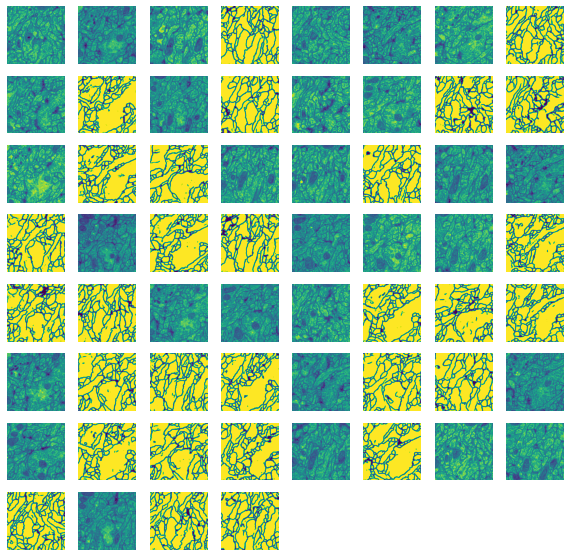

In [7]:
plt.figure(figsize=(10, 10))
for i, img in enumerate(img_array):
    plt.subplot(int(np.sqrt(n_imgs)) + 1, int(np.sqrt(n_imgs)) + 1, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [8]:
cd /content/unet

/content/unet


In [9]:
ls

data/              data.py  LICENSE  model.py   trainUnet.ipynb
dataPrepare.ipynb  img/     main.py  README.md


In [10]:
from model import *
from data import *

data_gen_args = dict(rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     fill_mode='nearest')

train_path = '/content/drive/My Drive/datasets/tgs_salt/train_data'
test_path = '/content/drive/My Drive/datasets/tgs_salt/test_data'
myGene = trainGenerator(1, train_path, 'images', 'masks', data_gen_args, save_to_dir=None)

In [11]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from tensorflow.keras.optimizers import Adam


def unet(input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(learning_rate=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [ ]:
model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss', verbose=1, save_best_only=True)
model.fit(myGene, batch_size=500, epochs=1, callbacks=[model_checkpoint])

In [14]:
test_list = glob.glob(test_path + '/images/*' + ".png")
len(test_list)

18000

In [15]:
def testGenerator(test_path,
                  num_image=30,
                  target_size=(256, 256),
                  flag_multi_class=False,
                  as_gray=True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_list[i]), as_gray=as_gray)
        img = img / 255.
        img = trans.resize(img, target_size)
        img = np.reshape(img, img.shape + (1,)) if not flag_multi_class else img
        img = np.reshape(img, (1,) + img.shape)
        yield img

In [33]:
testGene = testGenerator(os.path.join(test_path, 'images'))
results = model.predict(testGene, batch_size=30, verbose=1)
saveResult(os.path.join(test_path, 'results'), results)

30/30 [==============================] - 4s 125ms/step


/content/unet/data.py:124: UserWarning: /content/drive/My Drive/datasets/tgs_salt/test_data/results/0_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
/content/unet/data.py:124: UserWarning: /content/drive/My Drive/datasets/tgs_salt/test_data/results/1_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
/content/unet/data.py:124: UserWarning: /content/drive/My Drive/datasets/tgs_salt/test_data/results/2_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
/content/unet/data.py:124: UserWarning: /content/drive/My Drive/datasets/tgs_salt/test_data/results/3_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
/content/unet/data.py:124: UserWarning: /content/drive/My Drive/datasets/tgs_salt/test_data/results/4_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
/content/u

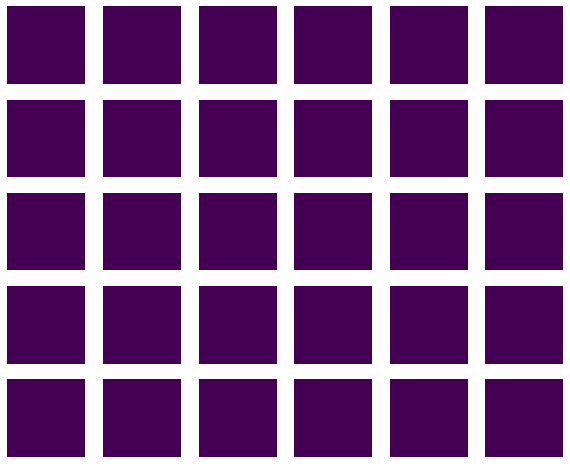

In [34]:
pred_list = glob.glob(test_path + '/results/*' + ".png")

from matplotlib import pyplot as plt
import cv2
import re
from PIL import Image
import numpy as np

height = 256
width = 256
img_array = np.empty((0, height, width))
n_imgs = len(pred_list)

plt.figure(figsize=(10, 10))
for itr, img in enumerate(pred_list):
        img_tensor = Image.open(img)
        img_tensor = np.asarray(img_tensor)
        img_tensor = cv2.resize(img_tensor, dsize=(height, width))
        img_tensor = img_tensor.reshape(1, height, width)
        img_array = np.append(img_array, img_tensor, axis=0)

for itr, img in enumerate(img_array):
    plt.subplot(int(np.sqrt(n_imgs))+1, int(np.sqrt(n_imgs))+1, itr+1)
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

# [Problem 2] Code reading



*   In the paper, a network and training strategy has been presented relying on the strong use of data augmentation. The fully conventional network has been modified and extended for more precise segmentations results.
*   Based on the code, we see that the implementation is done in many levels. The data.py has functions for converting image data to numerical data (adjustData), for expanding the image data for training (trainGenerator), for reading the test image (trainGenerator), for the normalization (labelVisualize) and for saving the results of the estimation (saveResult). the different instantitations are located in the main.py and the model.py is where the model itself is define like the pooling, activation, up-sampling and so on.


